# Deep Learning for Advanced Object Detection

### Install Required Packages

In [2]:
import sys
print(sys.version)

3.12.0 (v3.12.0:0fb18b02c8, Oct  2 2023, 09:45:56) [Clang 13.0.0 (clang-1300.0.29.30)]


In [3]:
!pip install labelme tensorflow opencv-python matplotlib albumentations pandas


### Import packages

In [4]:
import os
import time
import uuid
import cv2
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt
import albumentations as alb

### Collecting Primary Data/Images Using OpenCV

In [35]:
img_path = '/Users/christianingul/Desktop/DL/data/images'
number_images = 33

In [36]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(img_path,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(1) #Can be changed to allow more time

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()

### Label your images using LabelMe

In [3]:
!labelme # a & d allows you to go back and forth

2024-04-25 16:58:43,158 [INFO   ] __init__:get_config:67- Loading config file from: /Users/christianingul/.labelmerc


### Load images into a Tensorflow Data Pipeline

In [35]:
images = tf.data.Dataset.list_files('new_venv/data/images/*.jpg') #*.jpg allows us to do a wild card search
#We also convert our images into a TensorFlow 'Dataset' object that is designed to work with a large collection of image files efficiently

In [36]:
def load_image(x): #This function decodes the JPEG-encoded image stored in the string tensor byte_img into a tensor that TensorFlow can work with. The output is a 3-D tensor representing the image. 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [37]:
images = images.map(load_image) #.map() applies this function to each image 

### Splitting data into training, validation and testing folders

### Code to move the matching labels to matching images

In [38]:
import os 

for folder in ['train', 'test', 'val']:
    image_folder = os.path.join('DL/data', folder, 'images')
    for file in os.listdir(image_folder):
        # print(file)
        
        filename = file.split('.')[0] + '.json'
        # print(filename)
        existing_filepath = os.path.join('new_venv/data', 'labels', filename)
        print(existing_filepath)
        
        if os.path.exists(existing_filepath): 
            print('Executing')
            new_filepath = os.path.join('new_venv/data', folder, 'labels', filename)
            print(new_filepath)
            
            os.replace(existing_filepath, new_filepath)

FileNotFoundError: [Errno 2] No such file or directory: 'DL/data/train/images'

## Image Augmentation - Using Albumentations

In [40]:
img_augmentor = alb.Compose([
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', label_fields=['class_labels']))  

NameError: name 'alb' is not defined

## Creating an Augmentation Pipeline

### Running the Augmentation Pipeline

In [41]:
#Defining a dictionary, which will later be used to convert names to integers
class_labels = {
    'sharon': 0,
    'adi': 1,
    'christian': 2,
    'none': 3  # Using this for cases with no detected face
}


In [156]:
for partition in ['train', 'test', 'val']:
    image_folder = os.path.join('/Users/christianingul/Desktop/DL/data', partition, 'images')
    for image in os.listdir(image_folder):
        img = cv2.imread(os.path.join(image_folder, image))
        if img is None:
            continue  # Skip if the image is not loaded properly

        coords = [0, 0, 0.00001, 0.00001]  # Default coordinates
        label_path = os.path.join('/Users/christianingul/Desktop/DL/data', partition, 'labels', f'{image.split(".")[0]}.json')
        class_label = 3  # Default class for no detected face

        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)
            if label['shapes']:  # Check if there are any annotations
                coords = [label['shapes'][0]['points'][0][0], label['shapes'][0]['points'][0][1],
                          label['shapes'][0]['points'][1][0], label['shapes'][0]['points'][1][1]]
                coords = list(np.divide(coords, [1280, 720, 1280, 720]))  # Normalize coordinates
                class_label = class_labels[label['shapes'][0]['label']]  # Convert string label to integer

        try:
            for x in range(60):  # Augment each image 60 times
                augmented = img_augmentor(image=img, bboxes=[coords], class_labels=[[class_label]])  # Ensure class label is integer
                cv2.imwrite(os.path.join('/Users/christianingul/Desktop/DL/aug_data', partition, 'images', 
                                         f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {'image': f'{image.split(".")[0]}.{x}.jpg'}
                if len(augmented['bboxes']) > 0:
                    annotation['bbox'] = augmented['bboxes'][0]
                    annotation['class'] = augmented['class_labels'][0]  # Ensure correct indexing
                else:
                    annotation['bbox'] = [0, 0, 0, 0]
                    annotation['class'] = 3  # Use the integer for 'none'

                with open(os.path.join('/Users/christianingul/Desktop/DL/aug_data', partition, 'labels', 
                                       f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)


### Loading the newly created Augmented Images to our Tensorflow Dataset

In [7]:
train_images = tf.data.Dataset.list_files('/Users/christianingul/Desktop/DL/aug_data/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_images = train_images.map(lambda x: tf.image.resize(x, (224,224)), num_parallel_calls=tf.data.AUTOTUNE)  # Resizing the image to 224x224 to match MobileNetV2
train_images = train_images.map(lambda x: tf.ensure_shape(x / 255, (224, 224, 3)), num_parallel_calls=tf.data.AUTOTUNE)  # Normalizing images, so they are between 0 & 1


In [8]:
test_images = tf.data.Dataset.list_files('/Users/christianingul/Desktop/DL/aug_data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image,num_parallel_calls=tf.data.AUTOTUNE)
test_images = test_images.map(lambda x: tf.image.resize(x, (224,224)),num_parallel_calls=tf.data.AUTOTUNE)
test_images = test_images.map(lambda x: tf.ensure_shape(x / 255, (224, 224, 3)),num_parallel_calls=tf.data.AUTOTUNE)

In [9]:
val_images = tf.data.Dataset.list_files('/Users/christianingul/Desktop/DL/aug_data/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image,num_parallel_calls=tf.data.AUTOTUNE)
val_images = val_images.map(lambda x: tf.image.resize(x, (224,224)),num_parallel_calls=tf.data.AUTOTUNE)
val_images = val_images.map(lambda x: tf.ensure_shape(x / 255, (224, 224, 3)),num_parallel_calls=tf.data.AUTOTUNE)

### Creating a Label Loading Function

In [1]:
def load_labels(label_path):
    # Convert the tensor to a numpy string within the TensorFlow graph
    label_path = label_path.numpy().decode("utf-8")
    
    with open(label_path, 'r', encoding="utf-8") as file:
        label_data = json.load(file)
        class_label = label_data['class']  #integers here
        bbox = label_data['bbox']

    # Convert class label and bbox to tensors
    class_label_tensor = tf.convert_to_tensor(class_label, dtype=tf.int32) #Converting integers to tensors
    bbox_tensor = tf.convert_to_tensor(bbox, dtype=tf.float32)

    return class_label_tensor, bbox_tensor


### Loading our Labels to the Tensorflow Dataset

In [12]:
def set_shapes(class_label, bbox): #Sets the shape of the Tensors
    class_label.set_shape([1]) #May need to be dynamic to account for 1-2 classes
    bbox.set_shape([4]) #Bounding box [x_min, y_min, x_max, y_max], hence shape 4,
    return class_label, bbox 

In [13]:
train_labels = tf.data.Dataset.list_files('/Users/christianingul/Desktop/DL/aug_data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.int32, tf.float32]),
                                num_parallel_calls=tf.data.AUTOTUNE)

In [14]:
train_labels = train_labels.map(set_shapes,num_parallel_calls=tf.data.AUTOTUNE) #Sets the shape of the Tensors
#Bounding box [x_min, y_min, x_max, y_max], hence shape 4,

In [15]:
test_labels = tf.data.Dataset.list_files('/Users/christianingul/Desktop/DL/aug_data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.int32, tf.float32]),
                              num_parallel_calls=tf.data.AUTOTUNE)
test_labels = test_labels.map(set_shapes,num_parallel_calls=tf.data.AUTOTUNE)


In [16]:
val_labels = tf.data.Dataset.list_files('/Users/christianingul/Desktop/DL/aug_data/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.int32, tf.float32]),
                            num_parallel_calls=tf.data.AUTOTUNE)
val_labels = val_labels.map(set_shapes,num_parallel_calls=tf.data.AUTOTUNE)


### Final dataset - Merging images & labels

In [20]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)    # Shuffle the data
train = train.batch(10)         # Batch the data
train = train.prefetch(5)      # Prefetch 4 batches at a time to improve pipeline efficiency


In [21]:
train

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), (TensorSpec(shape=(None, 1), dtype=tf.int32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)))>

In [22]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1500)
test = test.batch(10)
test = test.prefetch(5)

In [23]:
test

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), (TensorSpec(shape=(None, 1), dtype=tf.int32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)))>

In [24]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1500)
val = val.batch(10)
val = val.prefetch(5)

In [25]:
val

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), (TensorSpec(shape=(None, 1), dtype=tf.int32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)))>

### Deep Learning Modeling - MobileNetV2


In [27]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2


def build_model(input_shape=(224, 224, 3)):
    # Load MobileNetV2 without the top layer and set it to use ImageNet weights
    base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
    
    # Set the layers in the base model to be non-trainable (optional)
    for layer in base_model.layers:
        layer.trainable = False  # You can fine-tune this based on your needs

    # Create the feature extractor part
    base_features = GlobalAveragePooling2D()(base_model.output) #Works similar to a flattening layer

    # Add classification and bounding box heads
    x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(base_features)
    x = Dropout(0.5)(x)
    class_output = Dense(4, activation='softmax', name='class_output')(x)

    y = Dense(1024, activation='relu',kernel_regularizer=l2(0.01))(base_features)
    y = Dropout(0.5)(y)
    bbox_output = Dense(4, activation='sigmoid', name='bbox_output')(y)

    # Construct the final model
    model = Model(inputs=base_model.input, outputs=[class_output, bbox_output])
    return model



### Loss Functions - Localization and Classification 

In [28]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2])) #Look up reduce_sum again
    #delta coord looks at the first two elements of our bounding box, which is the left side x,y coordinates
    delta_coord_weighted = 1.5 * delta_coord
    
    #Finding the true height and width              
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    #Finding the predicted height and width
    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    #Using the values above for our loss
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord_weighted + delta_size

# Display Model Architecture

In [ ]:
!pip install pydot

In [37]:
facetracker = build_model()

from keras.utils import plot_model
plot_model(facetracker, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


You must install pydot (`pip install pydot`) for `plot_model` to work.


### Compiling & Training Model

In [29]:
from tensorflow.keras.optimizers import Adam
from tensorflow import keras

# Define the model
facetracker = build_model()

# Compile the model
facetracker.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss={
        'class_output': 'sparse_categorical_crossentropy', #class_output, bbox_output
        'bbox_output': localization_loss
    },
    loss_weights={
        'class_output': 1.0,  # Normal weight for classification
        'bbox_output': 1.5   # Increased weight for bounding box regression
    },
    metrics={
        'class_output': ['accuracy'],
        'bbox_output': ['mse']
    })

logdir='logs'

callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor="val_bbox_output_mse",
        mode='min', #Consider changing to 'min' and monitoring mse
        patience=4
    ),
    tf.keras.callbacks.TensorBoard(log_dir='logs')
]



# Train the model
history = facetracker.fit(
    train,
    validation_data=val,
    epochs=40,
    callbacks=callbacks_list  # Add any callbacks like TensorBoard, ModelCheckpoint, etc.
)


Epoch 1/40


2024-04-27 19:05:58.613175: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 3074 of 5000
2024-04-27 19:06:15.046596: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


420/420 ━━━━━━━━━━━━━━━━━━━━ 254s 519ms/step - bbox_output_mse: 0.0572 - class_output_accuracy: 0.8674 - loss: 24.1340 - val_bbox_output_mse: 0.0485 - val_class_output_accuracy: 0.9156 - val_loss: 16.7586
Epoch 2/40


2024-04-27 19:10:04.679647: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 997 of 5000
2024-04-27 19:10:14.679491: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 2500 of 5000
2024-04-27 19:10:23.834400: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


420/420 ━━━━━━━━━━━━━━━━━━━━ 220s 452ms/step - bbox_output_mse: 0.0172 - class_output_accuracy: 0.9995 - loss: 13.6177 - val_bbox_output_mse: 0.0440 - val_class_output_accuracy: 0.8956 - val_loss: 12.3114
Epoch 3/40


2024-04-27 19:13:44.337684: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 2541 of 5000
2024-04-27 19:13:53.305664: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


420/420 ━━━━━━━━━━━━━━━━━━━━ 198s 425ms/step - bbox_output_mse: 0.0114 - class_output_accuracy: 0.9985 - loss: 9.5849 - val_bbox_output_mse: 0.0409 - val_class_output_accuracy: 0.9156 - val_loss: 9.6651
Epoch 4/40


2024-04-27 19:17:02.251476: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 3053 of 5000
2024-04-27 19:17:06.366400: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


420/420 ━━━━━━━━━━━━━━━━━━━━ 181s 396ms/step - bbox_output_mse: 0.0079 - class_output_accuracy: 0.9988 - loss: 7.2326 - val_bbox_output_mse: 0.0402 - val_class_output_accuracy: 0.9456 - val_loss: 7.8689
Epoch 5/40


2024-04-27 19:20:02.821410: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 1932 of 5000
2024-04-27 19:20:11.251588: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


420/420 ━━━━━━━━━━━━━━━━━━━━ 186s 398ms/step - bbox_output_mse: 0.0059 - class_output_accuracy: 0.9979 - loss: 5.6626 - val_bbox_output_mse: 0.0395 - val_class_output_accuracy: 0.9167 - val_loss: 6.7589
Epoch 6/40


2024-04-27 19:23:09.232320: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 2888 of 5000
2024-04-27 19:23:17.070159: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


420/420 ━━━━━━━━━━━━━━━━━━━━ 191s 412ms/step - bbox_output_mse: 0.0050 - class_output_accuracy: 0.9991 - loss: 4.5082 - val_bbox_output_mse: 0.0402 - val_class_output_accuracy: 0.9156 - val_loss: 5.9021
Epoch 7/40


2024-04-27 19:26:20.691690: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 2839 of 5000
2024-04-27 19:26:25.724852: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


420/420 ━━━━━━━━━━━━━━━━━━━━ 183s 399ms/step - bbox_output_mse: 0.0040 - class_output_accuracy: 0.9985 - loss: 3.5923 - val_bbox_output_mse: 0.0390 - val_class_output_accuracy: 0.9167 - val_loss: 5.1976
Epoch 8/40


2024-04-27 19:29:23.276516: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 2886 of 5000
2024-04-27 19:29:27.694040: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


420/420 ━━━━━━━━━━━━━━━━━━━━ 161s 349ms/step - bbox_output_mse: 0.0037 - class_output_accuracy: 0.9992 - loss: 2.8826 - val_bbox_output_mse: 0.0379 - val_class_output_accuracy: 0.9167 - val_loss: 4.4341
Epoch 9/40


2024-04-27 19:32:04.246730: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 2505 of 5000
2024-04-27 19:32:14.252188: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 3776 of 5000
2024-04-27 19:32:18.871448: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


420/420 ━━━━━━━━━━━━━━━━━━━━ 203s 423ms/step - bbox_output_mse: 0.0034 - class_output_accuracy: 0.9991 - loss: 2.3018 - val_bbox_output_mse: 0.0383 - val_class_output_accuracy: 0.9322 - val_loss: 3.8234
Epoch 10/40


2024-04-27 19:35:27.064197: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 1742 of 5000
2024-04-27 19:35:36.751203: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


420/420 ━━━━━━━━━━━━━━━━━━━━ 186s 397ms/step - bbox_output_mse: 0.0030 - class_output_accuracy: 0.9983 - loss: 1.8408 - val_bbox_output_mse: 0.0392 - val_class_output_accuracy: 0.8244 - val_loss: 4.3800


### Evaluate model on the testing set

In [30]:
test_metrics = facetracker.evaluate(test, verbose=2) #Obviously overfitting.
test_metrics

84/84 - 26s - 315ms/step - bbox_output_mse: 0.0179 - class_output_accuracy: 0.9702 - loss: 2.3859


[2.385934591293335, 0.017852500081062317, 0.9702380895614624]

### Plotting the Model Performance on training and validation data

In [47]:
import pandas as pd

history = pd.DataFrame(history.history)
history


,bbox_output_mse,class_output_accuracy,loss,val_bbox_output_mse,val_class_output_accuracy,val_loss
0,0.035091,0.954762,20.050400,0.048029,0.916667,16.637756
1,0.014332,0.997857,12.271797,0.044624,0.925556,12.013009
2,0.009583,0.998333,8.709060,0.043308,0.924444,9.503109
3,0.006775,0.999286,6.556333,0.041379,0.927778,7.764033
4,0.005507,0.999286,5.109146,0.041340,0.928889,6.551136
5,0.004402,0.998571,4.026575,0.040207,0.916667,5.642350
6,0.003885,0.998095,3.205570,0.040074,0.933333,4.872122
7,0.003374,0.998333,2.554812,0.040573,0.915556,4.368878
8,0.003259,0.999286,2.043634,0.038855,0.916667,3.854361
9,0.002918,0.998810,1.641337,0.039027,0.916667,3.517476


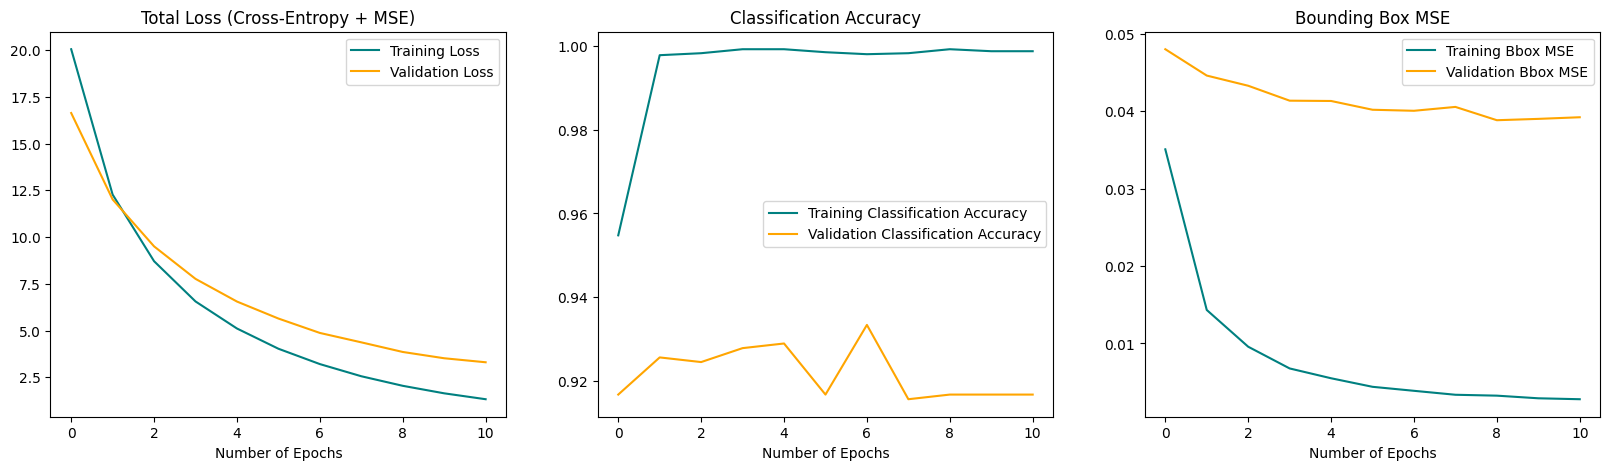

In [48]:
# Adjusting the plot based on actual keys and labels
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

# First subplot for overall loss
ax[0].plot(history['loss'], color='teal', label='Training Loss')
ax[0].plot(history['val_loss'], color='orange', label='Validation Loss')
ax[0].set_title('Total Loss (Cross-Entropy + MSE)')
ax[0].set_xlabel('Number of Epochs')
ax[0].legend()

# Second subplot for classification accuracy
ax[1].plot(history['class_output_accuracy'], color='teal', label='Training Classification Accuracy')
ax[1].plot(history['val_class_output_accuracy'], color='orange', label='Validation Classification Accuracy')
ax[1].set_title('Classification Accuracy')
ax[1].set_xlabel('Number of Epochs')
ax[1].legend()

# Third subplot for regression loss
ax[2].plot(history['bbox_output_mse'], color='teal', label='Training Bbox MSE')
ax[2].plot(history['val_bbox_output_mse'], color='orange', label='Validation Bbox MSE')
ax[2].set_title('Bounding Box MSE')
ax[2].set_xlabel('Number of Epochs')
ax[2].legend()

plt.show()

### Display Bounding Box and Classification on Testing Data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


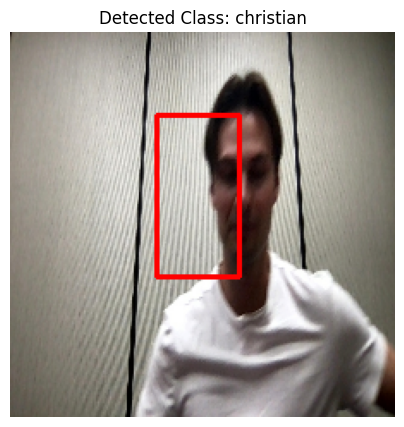

In [88]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
class_names = ['sharon', 'adi', 'christian', 'none']

test_data = test.as_numpy_iterator()
test_sample = test_data.next()
yhat = facetracker.predict(test_sample[0])
fig, ax = plt.subplots(figsize=(5, 5))  # Single subplot

# Assuming 'test_sample[0]' contains images and 'yhat' contains predictions
# Ensure there is at least one prediction and one test image
if len(test_sample[0]) > 0 and len(yhat[1]) > 0:
    sample_image = test_sample[0][0]  # First image
    sample_coords = yhat[1][0]       # First set of bounding box coordinates
    sample_image = np.array(sample_image).copy()
    class_probs = yhat[0][0]         # First set of class probabilities
    class_id = np.argmax(class_probs)
    max_prob = class_probs[class_id]
    
    if max_prob > 0.3:  # Change this threshold as needed
        x_min, y_min = np.multiply(sample_coords[:2], [224, 224]).astype(int)
        x_max, y_max = np.multiply(sample_coords[2:], [224, 224]).astype(int)
        cv2.rectangle(sample_image, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)

        # Optional: Draw label rectangle and text
        label_rect_start = (x_min, y_min - 30)
        label_rect_end = (x_min + 80, y_min)
        #cv2.rectangle(sample_image, label_rect_start, label_rect_end, (255, 0, 0), -1)
        #cv2.putText(sample_image, (x_min, y_min - 5), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    ax.imshow(sample_image)
    ax.set_title('Detected Class: ' + str(class_names[class_id]))
    ax.axis('off')

plt.show()


## Real Time Prediction using OpenCV

In [34]:
# Initializing the video capture
cap = cv2.VideoCapture(0)

class_names = ['sharon', 'adi', 'christian', 'none']  # List corresponding to the indices

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        print("Failed to grab frame")
        break

    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (224, 224))
    
    # Predict using the model
    yhat = facetracker.predict(np.expand_dims(resized / 255.0, axis=0))
    sample_coords = yhat[1][0]  # Bounding box predictions - double index converts to column instead of vector
    class_probs = yhat[0][0]    # Class probabilities

    class_id = np.argmax(class_probs) #Returns index of class with the highest probability
    max_prob = class_probs[class_id] #Grabs corresponding probability value

    if max_prob > 0.3 and class_id != 3:  # Check for a significant probability and valid face
        
        #Rescaling normalized coordinates to match frame size
        x_min, y_min = np.multiply(sample_coords[:2], [frame.shape[1], frame.shape[0]]).astype(int)
        x_max, y_max = np.multiply(sample_coords[2:], [frame.shape[1], frame.shape[0]]).astype(int)

        # Draw the bounding box
        cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0, 0, 255), 1) #Controls color of bounding box, 2 size

        # Draw label rectangle and text
        label_text = class_names[class_id]  # Get the class name using the class ID
        label_rect_start = (x_min, y_min - 30) #This sets the starting point of the rectangle 30 pixels above the upper boundary of the bounding box to avoid overlapping with it.
        label_rect_end = (x_min + 80, y_min)#This sets the ending point of the rectangle 80 pixels to the right of the starting point, creating a rectangle width of 80 pixels.
        cv2.rectangle(frame, label_rect_start, label_rect_end, (0, 0, 255), -1)
        cv2.putText(frame, label_text,(x_min, y_min - 5), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2) #text is placed slightly above the upper boundary of the bounding box (5 pixels above) 

    cv2.imshow('FaceTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━

In [ ]:
#22 -44